In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

#### Simulation setup

In [2]:
dimensions = 3
sim = rw.Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**1
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]; 1pc
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions
        

source = rw.PointSourceOriented(gyro_radius, source_pos, nr_particles, pitch_angle, phi)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  10
energy:  10
source tpye: PointSourceOriented
pitch angle:  0.955393232541696
phi:  0.0


#### Propagator

In [4]:
nr_steps = 2*10**5
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
magnetic_field = rw.OrderedBackgroundField(10, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
#propagator.set_pitch_angle_const(False)
sim.add_propagator(propagator)
sim.propagator.get_description()

TypeError: Can't instantiate abstract class AnisotropicPropagator with abstract methods get_description_propagator_type

#### Observer

In [7]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
sim.add_observer(observer)
sim.observer.get_description()

number steps:  169
Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: TimeEvolutionObserverLog
steps [0:10]:  [ 1  2  3  4  5  6  7  8  9 10]
steps [-11:-1]:  [108304 115155 122439 130185 138420 147176 156486 166385 176910 188101]
nr steps:  169
substeps:  [False False  True]
all_steps:  False


In [10]:
%time sim.run_simulation()
sim.save_data('rwpropa/data/data_simulation')

CPU times: user 2.57 s, sys: 6.17 ms, total: 2.57 s
Wall time: 2.56 s


## Analyze statistics


init statistics plotting class


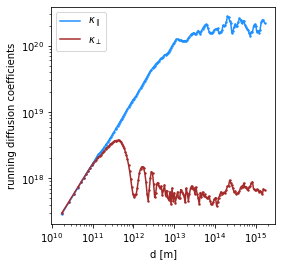

In [11]:
df = pd.read_pickle("rwpropa/data/data_simulation.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
dimensions = 3
sta = rw.Statistics(df_time_evolution_observer, dimensions)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

/home/patrick/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


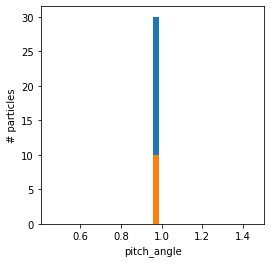

In [9]:
bins = 30
file_name = None
df_kappas = sta.plot_distribution('pitch_angle', -1, bins, file_name)

In [ ]:
df

init trajectory plotting class


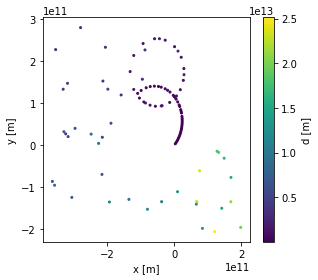

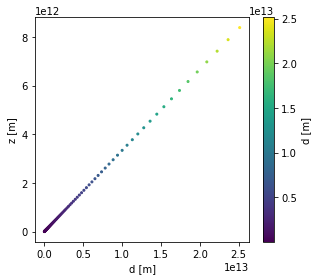

In [12]:
tra = Trajectory(df_time_evolution_observer, dimensions)
particle_ids = tra.get_particle_ids()
nr_steps = 100
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)
tra.plot_trajectory('d', 'z', 'd', particle_ids[0], nr_steps, None)

TypeError: object of type 'float' has no len()